(supervised:trees:regression-trees)=
# Regression Trees

Here we consider a concrete splitting (*variance reduction*) for growing regression trees as well as a concrete pruning algorithm (*cost-complexity pruning*) for regression trees.

## Variance reduction

Variance reduction aims at splitting nodes in a way yielding children with small variance. Nodes with small variance yield more precise predictions than nodes with large variance (remember: prediction = mean of targets of all training samples corresponding to the node).

Consider one node and the corresponding subset $S$ of the training data set $\{(x_1,y_1,\ldots,(x_n,y_n)\}$. Let
\begin{equation*}
I_S:=\{k\in\{1,\ldots,n\}:\,(x_k,y_k)\in S\}
\end{equation*}
be the index set holding all indices of samples in $S$ and denote mean and variance of targets in $S$ by
\begin{equation*}
m(S):=\frac{1}{|S|}\,\sum_{k\in I_S}y_k
\end{equation*}
and
\begin{equation*}
v(S):=\frac{1}{|S|}\,\sum_{k\in I_S}\bigl(y_k-m(S)\bigr)^2,
\end{equation*}
respectively.

Given a split $S=L\cup R$ into disjoint subsets $L$ and $R$ we look at the variances $v(L)$ and $v(R)$. For an arbitrary split it's not clear whether $v(L)$ and $v(R)$ are lower or higher than the original $v(S)$.

```{admonition} Example
Let $y_1=1$, $y_2=5$, $y_3=2$, $y_4=4$. Calculate $v(S)$ for $S=\{1, 2, 3, 4\}$ and then $v(L)$ and $v(R)$ for following splits:
* $L=\{1,3\}$, $\quad R=\{2,4\}$,
* $L=\{1,2\}$, $\quad R=\{3,4\}$.
```

Since we aim at low variance in the tree's leaves we would like to choose a split which minimizes both variances $v(L)$ and $v(R)$ at once. Optimization problems with multiple objective functions are hard to handle. So we look for an objective combining both variances. We simply could use the sum $v(L)+v(R)$, but then small subsets with low variance have the same weight as large subsets with low variance. Leafs corresponding to large subsets with low variance are good because they yield good predictions on many training samples, whereas leaves corresponding to small subsets do not matter so much. A better idea for a joint objective is a weighted sum of variances with weights representing subset sizes:
\begin{equation*}
\frac{|L|}{|S|}\,v(L)+\frac{|R|}{|S|}\,v(R).
\end{equation*}

Here is a script for comparing splits resulting from joint variance without and with weights:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

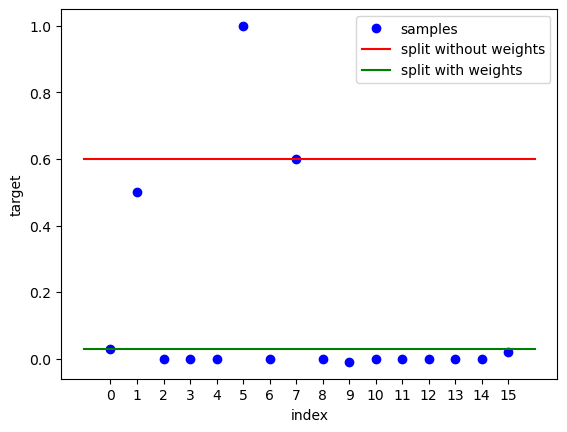

In [2]:
# targets of samples in set S
y = np.array([0.03, 0.5, 0, 0, 0, 1, 0, 0.6, 0, -0.01, 0, 0, 0, 0, 0, 0.02])

# all splitting points
splits = np.sort(np.unique(y))

# empty arrays to be filled with v(L), v(R), joint variance without/with weights
vL = np.empty(splits.size - 1)
vR = np.empty(splits.size - 1)
jv = np.empty(splits.size - 1)
jvw = np.empty(splits.size - 1)

# calculate joint variances
for k in range(0, splits.size - 1):
    yL = y[y <= splits[k]]    # targets in subset L
    yR = y[y > splits[k]]     # targets in subset R
    vL[k] = np.var(yL)
    vR[k] = np.var(yR)
    jv[k] = vL[k] + vR[k]
    jvw[k] = yL.size / y.size * vL[k] + yR.size / y.size * vR[k]

# splitting points for both variants
jv_split = splits[jv.argmin()]
jvw_split = splits[jvw.argmin()]

# plot targets and splitting points
fig, ax = plt.subplots()
ax.plot(y, 'ob', label='samples')
ax.plot([-1, y.size], [jv_split, jv_split], '-r', label='split without weights')
ax.plot([-1, y.size], [jvw_split, jvw_split], '-g', label='split with weights')
ax.legend()
ax.set_xticks(range(y.size))
ax.set_xlabel('index')
ax.set_ylabel('target')
plt.show()

Note, that the formula for joint variance can be reduced to
\begin{equation*}
\frac{|L|}{|S|}\,v(L)+\frac{|R|}{|S|}\,v(R)
=\frac{1}{|S|}\,\left(\sum_{k\in I_L}\bigl(y_k-m(L)\bigr)^2+\sum_{k\in I_R}\bigl(y_k-m(R)\bigr)^2\right).
\end{equation*}
If we take into account that the mean is the best constant approximation to the targets of a set of samples, we immediately see
\begin{equation*}
\sum_{k\in I_L}\bigl(y_k-m(L)\bigr)^2\leq\sum_{k\in I_L}\bigl(y_k-m(S)\bigr)^2\qquad\text{and}\qquad\sum_{k\in I_R}\bigl(y_k-m(R)\bigr)^2\leq\sum_{k\in I_R}\bigl(y_k-m(S)\bigr)^2.
\end{equation*}
Thus,
\begin{equation*}
\frac{|L|}{|S|}\,v(L)+\frac{|R|}{|S|}\,v(R)\leq v(S),
\end{equation*}
that is, the joint variance of the child nodes is smaller than the parent node's variance. This justifies calling the splitting rule *variance reduction*.


## Cost-Complexity Pruning

```{hint}
There exist several variants of *cost-complexity* pruning. Here we describe the variant implemented in Scikit-Learn.
```

In a trained tree each leaf corresponds to a subset S of training samples. For each leaf (or corresponding subset $S$) we may compute the variance $v(\text{leaf})$ in the same way as $v(S)$ above. For non-leaf nodes we may compute the joint variance of all leafs of the nodes subtree:
\begin{equation*}
v(\text{subtree}):=\sum_{\text{leaves of}\atop{\text{subtree}}}\frac{|\text{leaf}|}{|\text{subtree}|}\,v(\text{leaf}),
\end{equation*}
where $|\cdots|$ denotes the number of training samples corresponding to a leaf or to all leafs of subtree, respectively.

Joint variance of a tree is closely related to prediction quality. More precisely, joint variance is the tree's prediction error (MSE) on the training data.

Above we already met the important inequality
\begin{equation*}
v(\text{subtree})\leq v(\text{subtree replaced by corresponding leaf}).
\end{equation*}

If we remove a node (and all its descendants) from the tree, joint variance of the whole tree increases or remains unchanged. If it remains unchanged, the now smaller tree has same prediction quality as the larger one. If joint variance increases, we have to decide if increase is not too large compared to decrease of complexity. Complexity of a tree can be expressed as the total number of leaves. The trade-off between joint variance and complexity can be expressed by the *cost-complexity measure (CCM)*:
\begin{equation*}
CCM(\text{subtree}):=v(\text{subtree})+\alpha\cdot\text{leaves in subtree}.
\end{equation*}
The first summand expresses the prediction error, the second the complexity of the subtree. The regularization parameter $\alpha$ controls the trade-off between error and complexity.
CCM of a leaf (a subtree containing only one node) is
\begin{equation*}
CCM(\text{leaf})=v(\text{leaf})+\alpha.
\end{equation*}

If we replace a subtree by a leaf the first summand (error) in CCM increases and the second (complexity) decreases to one. For $\alpha=0$ we have $CCM(\text{subtree})\leq CMM(\text{subtree replaced by leaf})$, because prediction error dominates CCM. For very large $\alpha$ we have $CCM(\text{subtree})>CCM(\text{subtree replaced by leaf})$, because complexity dominates CCM.

Cost-complexity pruning for each non-leaf node replaces the corresponding subtree by a leaf if $CCM(\text{subtree})>CCM(\text{subtree replaced by leaf})$, that is, if the leaf will have smaller cost-complexity measure than the subtree. For $\alpha=0$ nothing will be pruned. The larger $\alpha$ the smaller the resulting tree will be. The hyperparameter $\alpha$ has to be chosen carefully like every other hyperparameter, for instance by comparing prediction quality on training and validation data sets.

Cost-complexity pruning sometimes is described by the following equivalent formulation:

For each non-leaf node look for $\alpha$ such that
\begin{equation*}
CCM(\text{subtree})=CCM(\text{subtree replaced by leaf}).
\end{equation*}
Such an $\alpha$ is called *effective $\alpha$*. The formula is
\begin{equation*}
\alpha=\frac{v(\text{subtree replaced by leaf})-v(\text{subtree})}{\text{leaves in subtree}-1}
\end{equation*}
For the effective $\alpha$ CCM does not change if we replace a subtree by a leaf. Small effective $\alpha$ indicates that prediction error changes only slightly while complexity is changed much more when replacing the subtree. Based on that observation we compute effective $\alpha$ for all subtrees and remove subtrees with effective $\alpha$ below some predefined upper bound. That upper bound is identical to the hyperparameter $\alpha$ above.

## Pruning versus Penalization

Formula for CCM are very similar to formula for regularizing loss function based learning methods (linear regression, ANNs). For loss function based methods we looked for minimizers of
\begin{equation*}
\text{loss}\bigl(\text{model(inputs)}, \text{targets}\bigr)+\alpha\cdot\text{penalty(inputs)}\to\min_{\text{model}},
\end{equation*}
over a certain class of models.
Following this idea, in regression tree learning we could ask for a tree minimizing
\begin{equation*}
\text{loss}\bigl(\text{model(inputs)}, \text{targets}\bigr)+\alpha\cdot\text{number of leaves}\to\min_{\text{model}}
\end{equation*}
over the set of all regression trees. Formulating such an optimization problem is not hard, but how to solve it? The objective is not differentiable and the search space (set of all trees) is extremely large.

Cost-complexity pruning solves this optimization problem for a much smaller search space. The pruned tree minimizes the objective over the set of all trees which can be obtained from the unpruned tree by removing nodes. The regularization parameter $\alpha$ in the objective is the lower bound for effective $\alpha$ values to keep. In this sense cost-complexity pruning fits well into the usual regularization framework.

## Regression Trees with Scikit-Learn

Scikit-Learn implements regression trees in [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn.tree as tree

rng = np.random.default_rng(0)

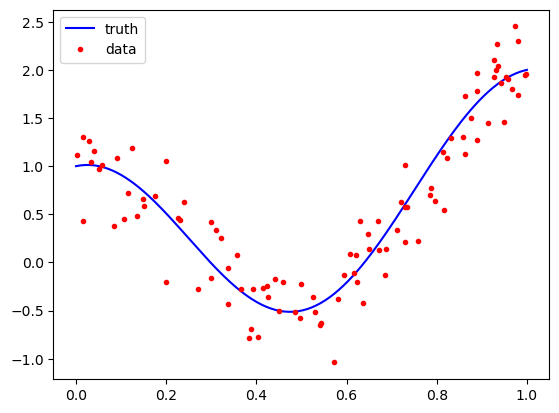

In [4]:
def truth(x):
    return x + np.cos(2 * np.pi * x)

xmin = 0
xmax = 1
x = np.linspace(xmin, xmax, 200)

n = 100    # number of data points to generate
noise_level = 0.3    # standard deviation of artificial noise

# simulate data
X = (xmax - xmin) * rng.random((n, 1)) + xmin
y = truth(X).reshape(-1) + noise_level * rng.standard_normal(n)

# plot truth and data
fig, ax = plt.subplots()
ax.plot(x, truth(x), '-b', label='truth')
ax.plot(X.reshape(-1), y, 'or', markersize=3, label='data')
ax.legend()
plt.show()

`DecisionTreeRegressor` takes several parameters for stopping growth of the tree and also supports cost-complexity pruning. For the latter the `ccp_alpha` parameter has to be specified. Nodes with smaller effective $\alpha$ will be removed. Scikit-Learn's default values for stopping criteria lead to trees with one training sample per leaf, that is, to maximum complexity.

To find good splits, Scikit-Learn uses variance reduction by default, but other techniques are available (parameter `criterion`). Further, instead of considering all possible splits, we may reduce computation time by considering fewer features or fewer splitting points (parameters `splitter` and `max_features`).

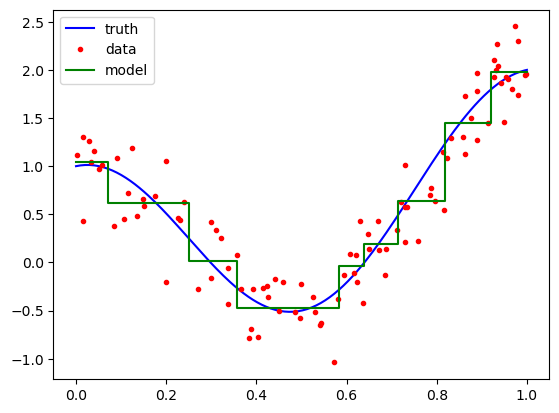

In [5]:
# regression
reg = tree.DecisionTreeRegressor(ccp_alpha=0.004)
reg.fit(X, y)

# get hypothesis for plotting
y_reg = reg.predict(x.reshape(-1, 1))

# plot truth, data, hypothesis
fig, ax = plt.subplots()
ax.plot(x, truth(x), '-b', label='truth')
ax.plot(X.reshape(-1), y, 'or', markersize=3, label='data')
ax.step(x, y_reg, '-g', label='model')
ax.legend()
plt.show()

Regression trees always yield piecewise constant hypotheses. The number of plateaus corresponds to the number of leaves.

Scikit-Learn provides the [`plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) function to visualize decision trees.

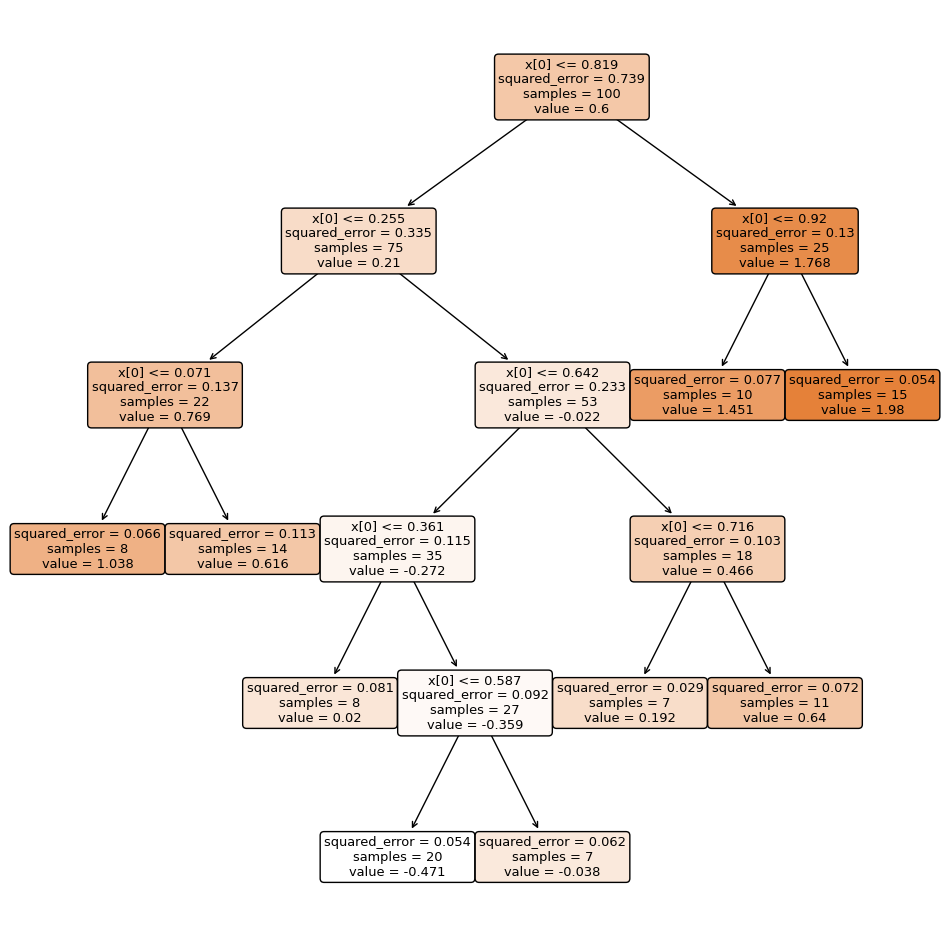

In [6]:
fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(reg, ax=ax, filled=True, rounded=True)
plt.show()